# Forward Neural network

The forward model is a resnet model.


## Import modules

In [1]:
import os
import math
import numpy as np
import pandas as pd
import pickle
import h5py
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

2025-03-18 16:50:58.575830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742313058.635685 2771533 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742313058.653021 2771533 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 16:50:58.780108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set dynamic GPU memory growth

In [2]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


## Load preprocessed data

In [3]:
hdf5_file_name = "datasets/core_shell_particles_preprocessed_122500.h5"

f = h5py.File(hdf5_file_name, "r")
X_train = np.array(f["X_train"])
y_train = np.array(f["y_train"])
X_test = np.array(f["X_test"])
y_test = np.array(f["y_test"])
f.close()

In [4]:
X_train[0].shape

(16,)

### Custom Resnet model

#### Resblock

In [5]:
# decorator to register the custom resblock to allow serialziation and re-loading
@keras.utils.register_keras_serializable()  # for keras3
class ResBlock1D(keras.Model):
    def __init__(self, filters, kernel_size=3, convblock=False, **kwargs):
        super(ResBlock1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        # setup all necessary layers
        self.conv1 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn1 = keras.layers.BatchNormalization()

        self.conv2 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn2 = keras.layers.BatchNormalization()

        # self.relu = keras.layers.LeakyReLU()
        self.relu = keras.layers.LeakyReLU(negative_slope=0.01)

        self.convblock = convblock
        if self.convblock:
            self.conv_shortcut = keras.layers.Conv1D(filters, 1)

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # add shortcut. optionally pass it through a Conv
        if self.convblock:
            x_sc = self.conv_shortcut(input_tensor)
        else:
            x_sc = input_tensor
        x += x_sc
        return self.relu(x)

    def get_config(self):
        base_config = super().get_config()
        return {
            "convblock": self.convblock,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            **base_config,
        }

#### Full resnet

In [6]:
N_rb = 4  # Nr of resblocks per size


def create_custom_resnet_model(input_shape):
    inputs = keras.layers.Input(shape=(input_shape,))

    x = inputs
    x = keras.layers.Dense(8192)(x)
    x = keras.layers.LeakyReLU(negative_slope=0.01)(x)
    x = keras.layers.Dense(4096)(x)
    x = keras.layers.LeakyReLU(negative_slope=0.01)(x)

    x = keras.layers.Dense(256 * 8)(x)
    x = keras.layers.LeakyReLU(negative_slope=0.01)(x)
    x = keras.layers.Reshape((8, 256))(x)

    for i in range(N_rb):
        x = ResBlock1D(filters=256)(x)
    x = keras.layers.UpSampling1D(size=2)(x)  # Upsample to length 16

    for i in range(N_rb):
        x = ResBlock1D(filters=256, convblock=(i == 0))(x)
    x = keras.layers.UpSampling1D(size=2)(x)  # Upsample to length 32

    for i in range(N_rb):
        x = ResBlock1D(filters=128, convblock=(i == 0))(x)
    x = keras.layers.UpSampling1D(size=2)(x)  # Upsample to length 64

    for i in range(N_rb):
        x = ResBlock1D(filters=128, convblock=(i == 0))(x)

    # Two output channels (forward and backward scattering)
    out_scat = keras.layers.Conv1D(2, kernel_size=1)(x)
    model = keras.Model(inputs=inputs, outputs=out_scat)

    return model

In [7]:
model_for_summary = create_custom_resnet_model(X_train.shape[1])
model_for_summary.summary()

I0000 00:00:1742313061.259381 2771533 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20403 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:21:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d (ResBlock1D)        │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_1 (ResBlock1D)      │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_2 (ResBlock1D)      │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_3 (ResBlock1D)      │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_4 (ResBlock1D)      │ (None, 16, 256)        │       461,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_5 (ResBlock1D)      │ (None, 16, 256)        │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_6 (ResBlock1D)      │ (None, 16, 256)        │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_7 (ResBlock1D)      │ (None, 16, 256)        │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_8 (ResBlock1D)      │ (None, 32, 128)        │       181,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_9 (ResBlock1D)      │ (None, 32, 128)        │        99,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_10 (ResBlock1D)     │ (None, 32, 128)        │        99,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_11 (ResBlock1D)     │ (None, 32, 128)        │        99,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_12 (ResBlock1D)     │ (None, 64, 128)        │       116,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_13 (ResBlock1D)     │ (None, 64, 128)        │        99,58

 Total params: 46,215,938 (176.30 MB)

 Trainable params: 46,203,650 (176.25 MB)

 Non-trainable params: 12,288 (48.00 KB)

## Train the model

### instantiate the model

In [8]:
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)
model = create_custom_resnet_model(X_train_new.shape[1])

### Parameters

In [9]:
initial_batch_size = 2
max_batch_size = 256
initial_lr = 0.0001
decay_factor = 0.5
step_size = 15
epochs = 300
validation_split = 0.1
patience = 20

# Set initial batch size and learning rate, history, best val loos, patience
current_batch_size = initial_batch_size
current_lr = initial_lr

history = {"loss": [], "val_loss": []}
best_val_loss = np.inf
patience_counter = 0

#  Compile Model
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss="mse")

### Train - Hybrid Method (Increase bacth size and Decay learning)


Epoch 1 - Training with Batch Size: 2, Learning Rate: 0.000100


I0000 00:00:1742313076.210416 2771852 service.cc:148] XLA service 0x7c2770003840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742313076.210589 2771852 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-18 16:51:16.661817: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742313078.155832 2771852 cuda_dnn.cc:529] Loaded cuDNN version 90300


   11/54000 ━━━━━━━━━━━━━━━━━━━━ 10:14 11ms/step - loss: 5.7265  

I0000 00:00:1742313083.740815 2771852 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54000/54000 ━━━━━━━━━━━━━━━━━━━━ 756s 14ms/step - loss: 0.0888 - val_loss: 0.0148
Epoch 1: Loss = 0.038199, Validation Loss = 0.014831

Epoch 2 - Training with Batch Size: 2, Learning Rate: 0.000100
54000/54000 ━━━━━━━━━━━━━━━━━━━━ 618s 11ms/step - loss: 0.0120 - val_loss: 0.0084
Epoch 2: Loss = 0.010420, Validation Loss = 0.008444

Epoch 3 - Training with Batch Size: 2, Learning Rate: 0.000100
54000/54000 ━━━━━━━━━━━━━━━━━━━━ 589s 11ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 3: Loss = 0.006835, Validation Loss = 0.007382

Epoch 4 - Training with Batch Size: 2, Learning Rate: 0.000100
54000/54000 ━━━━━━━━━━━━━━━━━━━━ 1024s 19ms/step - loss: 0.0055 - val_loss: 0.0077
Epoch 4: Loss = 0.005193, Validation Loss = 0.007676
Early stopping patience: 1/20

Epoch 5 - Training with Batch Size: 2, Learning Rate: 0.000100
54000/54000 ━━━━━━━━━━━━━━━━━━━━ 855s 16ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 5: Loss = 0.004244, Validation Loss = 0.005514

Epoch 6 - Training with Batch Size: 2

2025-03-18 22:15:42.631762: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:378] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 3.1785e-05 - val_loss: 5.9969e-05
Epoch 106: Loss = 0.000032, Validation Loss = 0.000060

Epoch 107 - Training with Batch Size: 256, Learning Rate: 0.000001
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 3.1470e-05 - val_loss: 5.9960e-05
Epoch 107: Loss = 0.000032, Validation Loss = 0.000060

Epoch 108 - Training with Batch Size: 256, Learning Rate: 0.000001
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 3.1589e-05 - val_loss: 5.9928e-05
Epoch 108: Loss = 0.000032, Validation Loss = 0.000060

Epoch 109 - Training with Batch Size: 256, Learning Rate: 0.000001
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 3.1758e-05 - val_loss: 5.9941e-05
Epoch 109: Loss = 0.000032, Validation Loss = 0.000060
Early stopping patience: 1/20

Epoch 110 - Training with Batch Size: 256, Learning Rate: 0.000001
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 3.1637e-05 - val_loss: 5.9940e-05
Epoch 110: Loss = 0.000032, Validation Loss = 0.000060
Ea

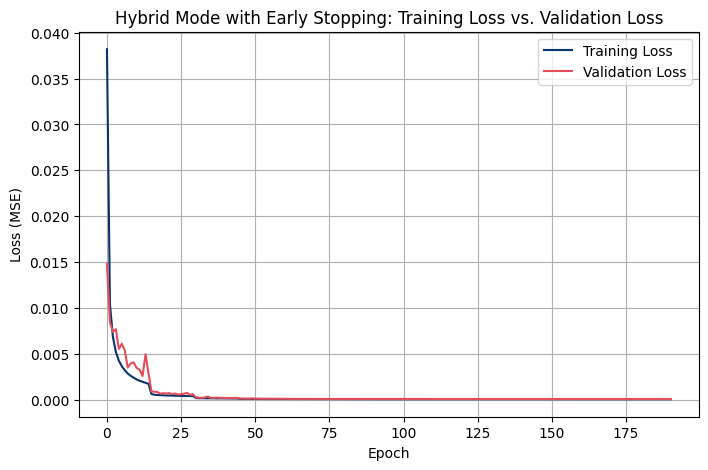

In [10]:
for epoch in range(epochs):
    print(
        f"\nEpoch {epoch+1} - Training with Batch Size: {current_batch_size}, Learning Rate: {current_lr:.6f}"
    )

    # Update the optimizer's learning rate
    model.optimizer.learning_rate.assign(float(current_lr))

    # Train for one epoch using model.fit
    hist = model.fit(
        X_train_new,
        y_train_new,
        batch_size=current_batch_size,
        epochs=1,
        verbose=1,
        validation_data=(X_val, y_val),
    )

    train_loss = hist.history["loss"][0]
    val_loss = hist.history["val_loss"][0]
    print(f"Epoch {epoch+1}: Loss = {train_loss:.6f}, Validation Loss = {val_loss:.6f}")

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

    # Update batch size and learning rate every `step_size` epochs
    if (epoch + 1) % step_size == 0:
        current_batch_size = min(current_batch_size * 2, max_batch_size)
        current_lr *= decay_factor
        print(
            f"Updated Batch Size: {current_batch_size}, Learning Rate: {current_lr:.6f}"
        )

# Plot the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history["loss"], color="#06346B", label="Training Loss")
plt.plot(history["val_loss"], color="#E34E5A", label="Validation Loss")
plt.title("Hybrid Mode with Early Stopping: Training Loss vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

### Save

In [11]:
# - save the model
model_filename = "models/resnet_Mie_predictor.keras"
model.save(model_filename)

# - save the training history
history_save_path = os.path.splitext(model_filename)[0] + "_hist.pkl"
with open(history_save_path, "wb") as f:
    pickle.dump(history, f)

### plot training convergence

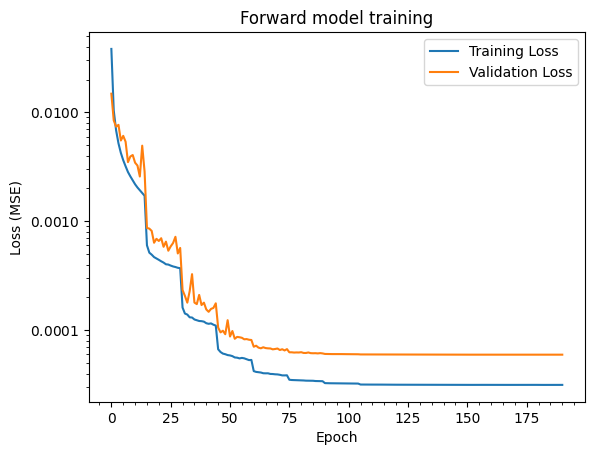

In [12]:
plt.figure()
plt.plot(history["loss"], label='Training Loss')
plt.plot(history["val_loss"], label='Validation Loss')

# Title and labels with a slightly larger font size
plt.title("Forward model training")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

plt.legend()
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.minorticks_on()  # Grid and minor ticks

plt.show()